In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import recpack
from recpack.datasets import MovieLens1M
from recpack.pipelines import PipelineBuilder
from recpack.scenarios import WeakGeneralization
from scipy.stats import kendalltau, linregress, pearsonr
from tqdm.notebook import tqdm

In [2]:
def init_latex_plots():
    new_rc_params = {'text.usetex': True,
        'svg.fonttype': 'none',
        'font.family': 'Linux Libertine',
        'text.latex.preamble': r'\usepackage{libertine}\usepackage{amsmath}',
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'libertine',
        'mathtext.it': 'libertine:italic',
        'mathtext.bf': 'libertine:bold'
        }
    mpl.rcParams.update(new_rc_params)
    plt.rc('axes', axisbelow=True)
init_latex_plots()

In [3]:
# Folder needs to exist, file will be downloaded if not present
# This can take a while
ml_loader = MovieLens1M(path='../data/', filename='ml-1M.csv')
data = ml_loader.load()

/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/datasets/movielens.py:252: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table(


  0%|          | 0/574385 [00:00<?, ?it/s]

  0%|          | 0/574385 [00:00<?, ?it/s]

In [4]:
seeds = np.arange(1)
scenarios = []
for seed in seeds:
    scenario = WeakGeneralization(0.5, validation=False, seed=seed)
    scenario.split(data)
    scenarios.append(scenario)

0it [00:00, ?it/s]

In [5]:
def run_pipeline(scenario, K):   
    builder = PipelineBuilder()
    
    for KUNN_k_u in np.linspace(70, 110, 9):
        for KUNN_k_i in np.linspace(70, 110, 9):
            builder.add_algorithm('KUNN', params={'Ku': int(KUNN_k_u), 'Ki': int(KUNN_k_i)})

    for l2 in np.linspace(500, 1600, 111):
        builder.add_algorithm('EASE', params={'l2': l2})
        
    builder.set_optimisation_metric('NDCGK', K=K)
    builder.add_metric('NDCGK', K=K)
    builder.add_metric('DCGK', K=K)
    builder.set_data_from_scenario(scenario)
    pipeline = builder.build()
    pipeline.run()

    return pipeline.get_metrics()

def collect_metrics(scenarios, K):
    dfs = [run_pipeline(scenario, K) for scenario in tqdm(scenarios)]
    
    x_ease = []
    y_ease = []
    x_kunn = []
    y_kunn = []
    for df in tqdm(dfs):
        display(df)
        for row in df.itertuples():
                        
            if row.Index[:4] == 'KUNN':
                x_kunn.append(getattr(row, f'DCGK_{K}'))
                y_kunn.append(getattr(row, f'NDCGK_{K}'))
            elif row.Index[:4] == 'EASE':
                x_ease.append(getattr(row, f'DCGK_{K}'))
                y_ease.append(getattr(row, f'NDCGK_{K}'))

    fontsize = 18
    figsize = (6.5,3)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    plt.scatter(x_ease, y_ease, color='maroon', marker='x', s=50, alpha=.75, label = r'\textsc{ease}\textsuperscript{r}')
    plt.scatter(x_kunn, y_kunn, color='darkgreen', marker='o', s=50, alpha=.75, label = r'\textsc{kunn}')
    
    x = x_ease + x_kunn
    y = y_ease + y_kunn
    
    lr = linregress(x, y)
    x_min, x_max = plt.gca().get_xlim()
    y_min, y_max = plt.gca().get_ylim()
    
    lr_y_min = lr.intercept + lr.slope * x_min
    lr_y_max = lr.intercept + lr.slope * x_max
    
    plt.plot([x_min, x_max], [lr_y_min, lr_y_max], ls='--', color='black', alpha=.9, label='Trend')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.xlabel(fr'DCG@{K}', fontsize=fontsize-2)
    plt.ylabel(fr'nDCG@{K}', fontsize=fontsize-2)
    
    plt.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)
    
    # Empirical P(Disagreement)
    N_corr = 0
    N_incorr = 0
    for x1, y1 in zip(x, y):
        for x2, y2 in zip(x, y):
            if x1 < x2 and y1 <= y2:
                N_corr += 1
            elif x1 > x2 and y1 >= y2:
                N_corr += 1
            elif x1 == x2 and y1 == y2:
                continue
            elif x1 == x2 and y1 != y2:
                N_incorr += 1
            else:
                N_incorr += 1
    P_disagreement = N_incorr / (N_corr + N_incorr)
    plt.title(r'Empirical $\mathsf{P}({\rm disagreement}) \approx' + f'{P_disagreement*100:.2f}\%' + '$', fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 

    plt.legend(fontsize=fontsize-2)
    plt.savefig('nDCG_disagreement_ML1M.pdf', bbox_inches='tight')
    plt.show()
    
    return x, y

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

2023-11-15 10:07:43,146 - base - recpack - INFO - Fitting KUNN complete - Took 0.31s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:07:50,393 - base - recpack - INFO - Fitting KUNN complete - Took 0.288s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:07:57,556 - base - recpack - INFO - Fitting KUNN complete - Took 0.295s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:04,837 - base - recpack - INFO - Fitting KUNN complete - Took 0.309s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:12,058 - base - recpack - INFO - Fitting KUNN complete - Took 0.31s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:19,305 - base - recpack - INFO - Fitting KUNN complete - Took 0.315s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:26,459 - base - recpack - INFO - Fitting KUNN complete - Took 0.323s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:33,699 - base - recpack - INFO - Fitting KUNN complete - Took 0.332s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:41,051 - base - recpack - INFO - Fitting KUNN complete - Took 0.345s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:48,353 - base - recpack - INFO - Fitting KUNN complete - Took 0.277s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:08:55,245 - base - recpack - INFO - Fitting KUNN complete - Took 0.289s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:02,081 - base - recpack - INFO - Fitting KUNN complete - Took 0.291s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:09,195 - base - recpack - INFO - Fitting KUNN complete - Took 0.298s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:16,443 - base - recpack - INFO - Fitting KUNN complete - Took 0.304s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:23,681 - base - recpack - INFO - Fitting KUNN complete - Took 0.313s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:30,982 - base - recpack - INFO - Fitting KUNN complete - Took 0.326s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:38,313 - base - recpack - INFO - Fitting KUNN complete - Took 0.335s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:45,616 - base - recpack - INFO - Fitting KUNN complete - Took 0.341s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:09:53,065 - base - recpack - INFO - Fitting KUNN complete - Took 0.278s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:00,115 - base - recpack - INFO - Fitting KUNN complete - Took 0.281s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:07,221 - base - recpack - INFO - Fitting KUNN complete - Took 0.288s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:14,453 - base - recpack - INFO - Fitting KUNN complete - Took 0.301s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:21,518 - base - recpack - INFO - Fitting KUNN complete - Took 0.307s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:28,907 - base - recpack - INFO - Fitting KUNN complete - Took 0.312s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:36,270 - base - recpack - INFO - Fitting KUNN complete - Took 0.324s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:43,515 - base - recpack - INFO - Fitting KUNN complete - Took 0.332s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:51,012 - base - recpack - INFO - Fitting KUNN complete - Took 0.349s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:10:58,827 - base - recpack - INFO - Fitting KUNN complete - Took 0.274s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:06,272 - base - recpack - INFO - Fitting KUNN complete - Took 0.286s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:13,730 - base - recpack - INFO - Fitting KUNN complete - Took 0.289s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:21,041 - base - recpack - INFO - Fitting KUNN complete - Took 0.296s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:28,100 - base - recpack - INFO - Fitting KUNN complete - Took 0.302s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:35,314 - base - recpack - INFO - Fitting KUNN complete - Took 0.313s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:42,647 - base - recpack - INFO - Fitting KUNN complete - Took 0.323s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:50,342 - base - recpack - INFO - Fitting KUNN complete - Took 0.332s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:11:57,869 - base - recpack - INFO - Fitting KUNN complete - Took 0.341s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:05,397 - base - recpack - INFO - Fitting KUNN complete - Took 0.276s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:12,380 - base - recpack - INFO - Fitting KUNN complete - Took 0.281s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:19,492 - base - recpack - INFO - Fitting KUNN complete - Took 0.289s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:26,964 - base - recpack - INFO - Fitting KUNN complete - Took 0.296s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:34,245 - base - recpack - INFO - Fitting KUNN complete - Took 0.307s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:41,515 - base - recpack - INFO - Fitting KUNN complete - Took 0.316s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:48,886 - base - recpack - INFO - Fitting KUNN complete - Took 0.326s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:12:56,691 - base - recpack - INFO - Fitting KUNN complete - Took 0.376s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:04,838 - base - recpack - INFO - Fitting KUNN complete - Took 0.344s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:12,859 - base - recpack - INFO - Fitting KUNN complete - Took 0.275s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:20,155 - base - recpack - INFO - Fitting KUNN complete - Took 0.282s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:27,482 - base - recpack - INFO - Fitting KUNN complete - Took 0.287s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:34,817 - base - recpack - INFO - Fitting KUNN complete - Took 0.296s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:42,168 - base - recpack - INFO - Fitting KUNN complete - Took 0.303s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:49,588 - base - recpack - INFO - Fitting KUNN complete - Took 0.314s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:13:57,074 - base - recpack - INFO - Fitting KUNN complete - Took 0.325s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:04,603 - base - recpack - INFO - Fitting KUNN complete - Took 0.337s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:12,295 - base - recpack - INFO - Fitting KUNN complete - Took 0.343s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:19,927 - base - recpack - INFO - Fitting KUNN complete - Took 0.274s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:26,991 - base - recpack - INFO - Fitting KUNN complete - Took 0.285s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:34,427 - base - recpack - INFO - Fitting KUNN complete - Took 0.287s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:41,833 - base - recpack - INFO - Fitting KUNN complete - Took 0.297s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:49,188 - base - recpack - INFO - Fitting KUNN complete - Took 0.303s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:14:56,607 - base - recpack - INFO - Fitting KUNN complete - Took 0.315s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:04,217 - base - recpack - INFO - Fitting KUNN complete - Took 0.347s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:11,925 - base - recpack - INFO - Fitting KUNN complete - Took 0.341s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:19,485 - base - recpack - INFO - Fitting KUNN complete - Took 0.342s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:27,032 - base - recpack - INFO - Fitting KUNN complete - Took 0.275s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:34,310 - base - recpack - INFO - Fitting KUNN complete - Took 0.28s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:41,503 - base - recpack - INFO - Fitting KUNN complete - Took 0.285s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:48,966 - base - recpack - INFO - Fitting KUNN complete - Took 0.295s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:15:56,551 - base - recpack - INFO - Fitting KUNN complete - Took 0.305s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:04,039 - base - recpack - INFO - Fitting KUNN complete - Took 0.322s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:11,658 - base - recpack - INFO - Fitting KUNN complete - Took 0.325s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:19,410 - base - recpack - INFO - Fitting KUNN complete - Took 0.334s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:27,318 - base - recpack - INFO - Fitting KUNN complete - Took 0.352s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:35,114 - base - recpack - INFO - Fitting KUNN complete - Took 0.274s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:42,338 - base - recpack - INFO - Fitting KUNN complete - Took 0.283s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:49,830 - base - recpack - INFO - Fitting KUNN complete - Took 0.289s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:16:57,277 - base - recpack - INFO - Fitting KUNN complete - Took 0.297s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:17:04,995 - base - recpack - INFO - Fitting KUNN complete - Took 0.318s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:17:12,401 - base - recpack - INFO - Fitting KUNN complete - Took 0.313s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:17:20,033 - base - recpack - INFO - Fitting KUNN complete - Took 0.326s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:17:27,760 - base - recpack - INFO - Fitting KUNN complete - Took 0.332s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:17:35,333 - base - recpack - INFO - Fitting KUNN complete - Took 0.342s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2023-11-15 10:17:44,152 - base - recpack - INFO - Fitting EASE complete - Took 1.47s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:17:48,649 - base - recpack - INFO - Fitting EASE complete - Took 1.42s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:17:53,152 - base - recpack - INFO - Fitting EASE complete - Took 1.43s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:17:57,693 - base - recpack - INFO - Fitting EASE complete - Took 1.47s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:02,229 - base - recpack - INFO - Fitting EASE complete - Took 1.46s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:06,891 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:11,473 - base - recpack - INFO - Fitting EASE complete - Took 1.51s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:16,008 - base - recpack - INFO - Fitting EASE complete - Took 1.45s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:20,509 - base - recpack - INFO - Fitting EASE complete - Took 1.42s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:25,077 - base - recpack - INFO - Fitting EASE complete - Took 1.48s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:29,635 - base - recpack - INFO - Fitting EASE complete - Took 1.48s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:34,223 - base - recpack - INFO - Fitting EASE complete - Took 1.51s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:38,935 - base - recpack - INFO - Fitting EASE complete - Took 1.62s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:43,591 - base - recpack - INFO - Fitting EASE complete - Took 1.56s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:48,306 - base - recpack - INFO - Fitting EASE complete - Took 1.61s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:52,837 - base - recpack - INFO - Fitting EASE complete - Took 1.42s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:18:57,432 - base - recpack - INFO - Fitting EASE complete - Took 1.5s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:02,090 - base - recpack - INFO - Fitting EASE complete - Took 1.57s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:06,858 - base - recpack - INFO - Fitting EASE complete - Took 1.63s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:11,501 - base - recpack - INFO - Fitting EASE complete - Took 1.54s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:16,176 - base - recpack - INFO - Fitting EASE complete - Took 1.58s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:20,745 - base - recpack - INFO - Fitting EASE complete - Took 1.47s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:25,354 - base - recpack - INFO - Fitting EASE complete - Took 1.51s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:29,969 - base - recpack - INFO - Fitting EASE complete - Took 1.5s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:34,631 - base - recpack - INFO - Fitting EASE complete - Took 1.57s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:39,303 - base - recpack - INFO - Fitting EASE complete - Took 1.57s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:43,985 - base - recpack - INFO - Fitting EASE complete - Took 1.58s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:48,673 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:53,389 - base - recpack - INFO - Fitting EASE complete - Took 1.6s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:19:57,975 - base - recpack - INFO - Fitting EASE complete - Took 1.48s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:02,676 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:07,386 - base - recpack - INFO - Fitting EASE complete - Took 1.57s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:12,015 - base - recpack - INFO - Fitting EASE complete - Took 1.53s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:16,647 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:21,277 - base - recpack - INFO - Fitting EASE complete - Took 1.53s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:25,904 - base - recpack - INFO - Fitting EASE complete - Took 1.53s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:30,607 - base - recpack - INFO - Fitting EASE complete - Took 1.6s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:35,265 - base - recpack - INFO - Fitting EASE complete - Took 1.56s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:39,952 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:44,607 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:49,263 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:53,951 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:20:58,513 - base - recpack - INFO - Fitting EASE complete - Took 1.45s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:03,164 - base - recpack - INFO - Fitting EASE complete - Took 1.56s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:07,885 - base - recpack - INFO - Fitting EASE complete - Took 1.6s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:12,540 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:17,171 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:21,905 - base - recpack - INFO - Fitting EASE complete - Took 1.61s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:26,598 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:31,220 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:35,909 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:40,526 - base - recpack - INFO - Fitting EASE complete - Took 1.51s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:45,132 - base - recpack - INFO - Fitting EASE complete - Took 1.51s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:49,853 - base - recpack - INFO - Fitting EASE complete - Took 1.63s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:54,525 - base - recpack - INFO - Fitting EASE complete - Took 1.57s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:21:59,148 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:04,234 - base - recpack - INFO - Fitting EASE complete - Took 1.97s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:08,792 - base - recpack - INFO - Fitting EASE complete - Took 1.43s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:13,358 - base - recpack - INFO - Fitting EASE complete - Took 1.46s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:17,974 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:22,576 - base - recpack - INFO - Fitting EASE complete - Took 1.5s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:27,232 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:31,917 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:36,608 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:41,288 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:45,975 - base - recpack - INFO - Fitting EASE complete - Took 1.58s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:51,035 - base - recpack - INFO - Fitting EASE complete - Took 1.9s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:22:55,839 - base - recpack - INFO - Fitting EASE complete - Took 1.69s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:00,587 - base - recpack - INFO - Fitting EASE complete - Took 1.62s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:06,069 - base - recpack - INFO - Fitting EASE complete - Took 2.36s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:10,748 - base - recpack - INFO - Fitting EASE complete - Took 1.57s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:15,514 - base - recpack - INFO - Fitting EASE complete - Took 1.65s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:20,288 - base - recpack - INFO - Fitting EASE complete - Took 1.65s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:25,050 - base - recpack - INFO - Fitting EASE complete - Took 1.64s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:29,798 - base - recpack - INFO - Fitting EASE complete - Took 1.63s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:34,504 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:39,323 - base - recpack - INFO - Fitting EASE complete - Took 1.7s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:44,061 - base - recpack - INFO - Fitting EASE complete - Took 1.62s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:48,866 - base - recpack - INFO - Fitting EASE complete - Took 1.69s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:53,609 - base - recpack - INFO - Fitting EASE complete - Took 1.64s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:23:58,338 - base - recpack - INFO - Fitting EASE complete - Took 1.61s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:03,048 - base - recpack - INFO - Fitting EASE complete - Took 1.59s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:07,909 - base - recpack - INFO - Fitting EASE complete - Took 1.73s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:12,678 - base - recpack - INFO - Fitting EASE complete - Took 1.66s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:17,624 - base - recpack - INFO - Fitting EASE complete - Took 1.83s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:22,706 - base - recpack - INFO - Fitting EASE complete - Took 1.96s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:28,165 - base - recpack - INFO - Fitting EASE complete - Took 2.1s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:32,915 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:37,516 - base - recpack - INFO - Fitting EASE complete - Took 1.45s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:42,058 - base - recpack - INFO - Fitting EASE complete - Took 1.41s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:46,803 - base - recpack - INFO - Fitting EASE complete - Took 1.51s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:51,459 - base - recpack - INFO - Fitting EASE complete - Took 1.5s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:24:56,135 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:00,751 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:05,664 - base - recpack - INFO - Fitting EASE complete - Took 1.8s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:10,246 - base - recpack - INFO - Fitting EASE complete - Took 1.48s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:14,823 - base - recpack - INFO - Fitting EASE complete - Took 1.42s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:19,457 - base - recpack - INFO - Fitting EASE complete - Took 1.54s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:24,106 - base - recpack - INFO - Fitting EASE complete - Took 1.55s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:28,769 - base - recpack - INFO - Fitting EASE complete - Took 1.56s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:33,435 - base - recpack - INFO - Fitting EASE complete - Took 1.56s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:38,068 - base - recpack - INFO - Fitting EASE complete - Took 1.54s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:42,714 - base - recpack - INFO - Fitting EASE complete - Took 1.56s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:47,330 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:52,023 - base - recpack - INFO - Fitting EASE complete - Took 1.6s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:25:56,647 - base - recpack - INFO - Fitting EASE complete - Took 1.52s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:26:01,276 - base - recpack - INFO - Fitting EASE complete - Took 1.53s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:26:06,580 - base - recpack - INFO - Fitting EASE complete - Took 2.18s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:26:11,097 - base - recpack - INFO - Fitting EASE complete - Took 1.43s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:26:15,659 - base - recpack - INFO - Fitting EASE complete - Took 1.47s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


2023-11-15 10:26:20,256 - base - recpack - INFO - Fitting EASE complete - Took 1.5s


/Users/olivierjeunen/Library/Python/3.9/lib/python/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


  0%|          | 0/1 [00:00<?, ?it/s]

,NDCGK_100,DCGK_100
"KUNN(Ki=70,Ku=70)",0.447293,4.955154
"KUNN(Ki=75,Ku=70)",0.448054,4.963528
"KUNN(Ki=80,Ku=70)",0.448097,4.964685
"KUNN(Ki=85,Ku=70)",0.449146,4.973631
"KUNN(Ki=90,Ku=70)",0.449767,4.978514
...,...,...
"EASE(alpha=0,density=None,l2=1560.0)",0.447419,4.975908
"EASE(alpha=0,density=None,l2=1570.0)",0.447298,4.974461
"EASE(alpha=0,density=None,l2=1580.0)",0.447230,4.973534
"EASE(alpha=0,density=None,l2=1590.0)",0.447173,4.972941


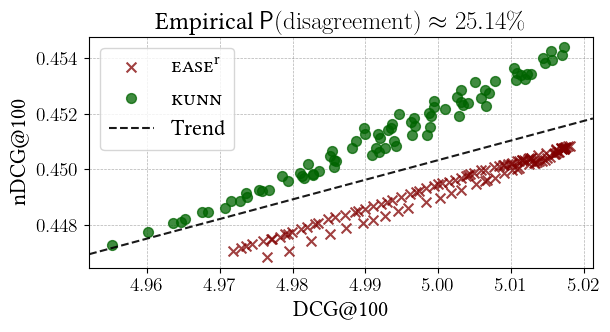

In [6]:
K=100
D, ND = collect_metrics(scenarios, K)

In [7]:
pearsonr(D,ND)

PearsonRResult(statistic=0.6324764592773364, pvalue=7.588684129294283e-23)

In [8]:
kendalltau(D, ND)

SignificanceResult(statistic=0.49727312390924955, pvalue=1.282702452475934e-24)